In [2]:
import numpy as np
import mmh3
import os
import pandas as pd
import matplotlib.pyplot as plt

## Functions for minhash

In [3]:
def shingle(aString, q, delimiter=' '):
    """
    Input:
        - aString (str): string to split into shingles
        - q (int)
        - delimiter (str): string of the delimiter to consider to split the input string (default: space)
    Return: list of unique shingles
    """
    
    all_shingles = []
    if delimiter != '':
        words_list = str(aString).split(delimiter)
    else:
        words_list = aString
    if len(words_list) < q:
        q = len(words_list)
    for i in range (len(words_list)-q+1):
        all_shingles.append(delimiter.join(words_list[i:i+q]))
    return list(set(all_shingles))

def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val 

def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = np.inf
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

def signature(df_reviews, q = 3, num_hashes = 100):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document idâ€™s as keys and signatures as values
    """
    dict_signatures = {}
    total_texts = len(df_reviews.index)
    counter = 1
    for ix, text in enumerate(df_reviews['Clean_Review']):
        #print(f'{counter}/{total_texts} - {ix} - Processing...')
        doc_shingles = shingle(text, q)
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[ix] = minhash_values
        counter += 1
    return dict_signatures


## Import data

In [4]:
root = os.getcwd()
df = pd.read_csv(root + "\clean_sample_data.csv")

## Create minhash signatures for each review

In [5]:
k = 100
b,r = 10, 10
assert k == b*r

sigs = signature(df, q = 1, num_hashes = k)


## Clustering based on minhash signatures

In [6]:
def dic_to_vec(dic):
    """
    Create matrix of signatures usable by sklearn.
    
    args:
        dic: Dictionary of review signatures
    returns:
        numpy matrix of dimensions (# of reviews, # of minhashes)
    """
    for ix, sig in enumerate(list(dic.items())):
        if ix == 0:
            X = np.array([sig[1]])
        else:
            X = np.append(X,[sig[1]],axis=0)
    return X

In [7]:
X = dic_to_vec(sigs)

In [8]:
y = np.array(df.overall.values)

## KMeans clustering

In [9]:
from sklearn.cluster import KMeans

In [10]:
# Initialize classifier
k_means = KMeans(n_clusters=5, random_state=0)

In [11]:
X_transform = k_means.fit_transform(X,y)

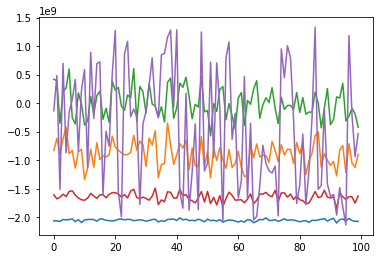

In [12]:
centroids = k_means.cluster_centers_

plt.plot(centroids.T)

In [13]:
def assign_cluster(centroid_list, dic):
    """
    Assigns each review to a cluster.
    
    Args:
        centroid_list: List of centroids in their vector format.
        dic: Dictionary of signatures of reviews.
    Returns:
        assignments: Dictionary of reviews and their cluster.
    """
    assignments = {}
    for ix, sig in enumerate(list(dic.items())):
        distances = []
        for j, centroid in enumerate(centroid_list):
            distances.append(np.linalg.norm(centroid-sig[1]))
        assignments[ix] = np.argmin(distances)
    return assignments

In [14]:
assigned = assign_cluster(centroids, sigs)

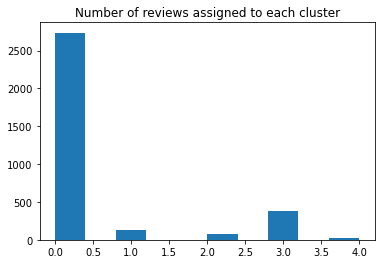

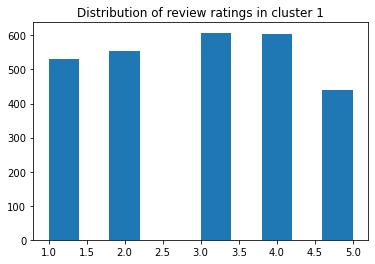

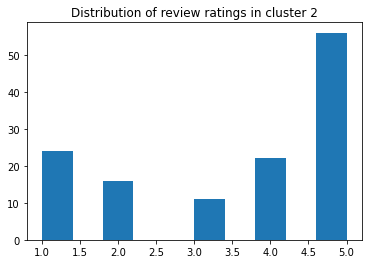

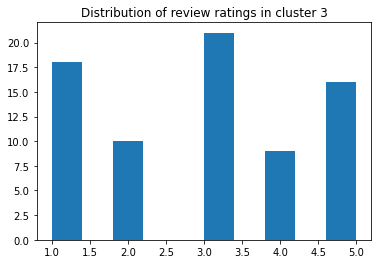

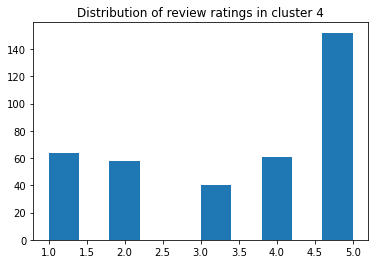

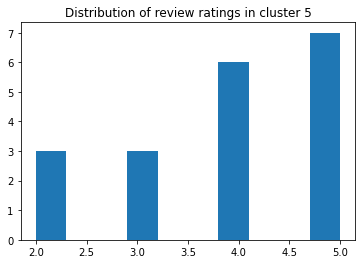

In [15]:
plt.hist(list(assigned.values()))
plt.title("Number of reviews assigned to each cluster")
plt.show()
for i in range(len(centroids)):
    df_slice = df.loc[pd.Series(list(assigned.values())) == i]
    #print(df_slice)
    #review_lengths = [len(df_slice.Clean_Review.values[i]) for i in range(len(df_slice.Clean_Review.values))]
    plt.hist(df_slice['overall'])
    plt.title(str("Distribution of review ratings in cluster "+ str(i+1)))
    plt.show()
    #plt.hist(review_lengths)
    #plt.show()

#### Subconclusion: Minhash vectorization does not result in meaningful clustering

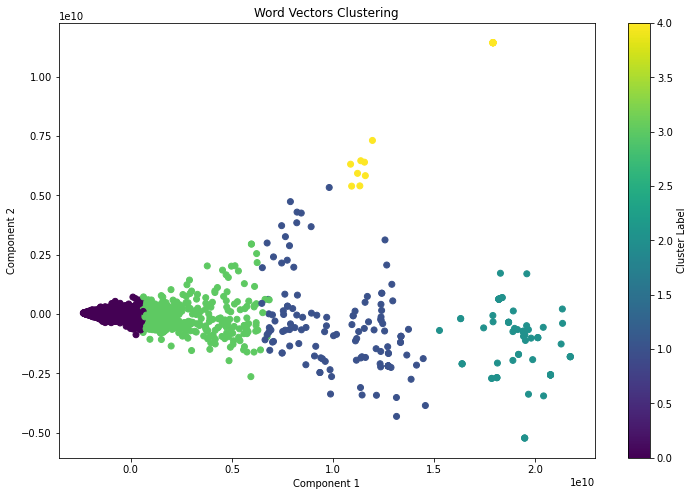

In [16]:
from sklearn.decomposition import PCA

labels = k_means.labels_

pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Word Vectors Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


## Defining basic tf-idf function

In [17]:
from collections import Counter

def get_word_usage(documents, n_t = None, min_appearances = 1):
    """ Called by tf_idf.
    Get number of document appearances for all words: """ 
    document_appearances = {}
    
    N = len(documents)
    
    for i in range(N):
        text = str(documents[i]).split(" ")
        unique_words = np.unique(text)
        for word in unique_words:
            if not(n_t is None) and n_t[word] < min_appearances:
                # If the word does not appear in enough documents to
                # be significant for the cluster in general.
                continue
            elif word not in document_appearances.keys():
                document_appearances[word] = 1
            else:
                document_appearances[word] = document_appearances[word] + 1
    return document_appearances, N

def calc_tf_idf(documents, N, n_t):
    tf_idf_sparse = []
    for i in range(N):
        text = str(documents[i]).split(" ")
        word_freq = Counter(text)
        max_freq = max(word_freq.values())
        
        tf_idf_vector = np.zeros(len(n_t))
        
        for word in word_freq.items():
            if word[0] in n_t.keys():
                index = list(n_t).index(word[0])
                tf_idf_vector[index] = word[1]/max_freq*np.log2(N/n_t[word[0]])
        
        tf_idf_sparse.append(tf_idf_vector)
    
    return np.asarray(tf_idf_sparse)


def get_tf_idf(df_docs):
    documents = np.array(df_docs.Clean_Review.values)
    
    n_t, N = get_word_usage(documents)

    tf_idf_sparse_matrix = calc_tf_idf(documents, N, n_t)
    
    return tf_idf_sparse_matrix, np.asarray(list(n_t.keys()))

### Get TF-IDF values for all documents

In [18]:
#tf_idf, features = get_tf_idf(df)

## TF_IDF for clusters

In [19]:
def merge_reviews(df, assignments):
    """ Collect all text from reviews in each cluster into a single string """
    assignments = np.asarray(list(assignments.values()))
    clusters = np.unique(assignments)
    documents = []
    for i in clusters:
        cluster_reviews = df.loc[assignments == i,"Clean_Review"].values
        all_text = str(cluster_reviews[0])
        for j in range(1, len(cluster_reviews)):
            all_text += " " + str(cluster_reviews[j])
        documents.append(all_text)
    
    return np.asarray(documents,str)


def get_tf_idf_cluster(df_docs, assignments, min_appearances = 1):
    documents = np.array(df_docs.Clean_Review.values)
    
    n_t_reviews, N = get_word_usage(documents)
    
    merged_documents = merge_reviews(df_docs, assignments)
    
    n_t_cluster, N = get_word_usage(merged_documents, n_t = n_t_reviews, min_appearances = min_appearances)
    
    tf_idf_sparse_matrix_clusters = calc_tf_idf(merged_documents, N, n_t_cluster)
    
    # Feature selection: Remove all features without weight in any class.
    key_mask = np.asarray(list(n_t_cluster.keys()))[tf_idf_sparse_matrix_clusters.sum(axis=0) > 0]
    array_mask = [word[0] in key_mask for word in n_t_cluster.items()]
    
    n_t_cluster = dict(filter(lambda x: x[0] in key_mask, n_t_cluster.items()))
    tf_idf_sparse_matrix_clusters = tf_idf_sparse_matrix_clusters[:,array_mask]
    
    tf_idf_sparse_matrix = calc_tf_idf(documents, len(documents), n_t_cluster)
    
    return tf_idf_sparse_matrix, tf_idf_sparse_matrix_clusters, n_t_cluster, n_t_reviews


def find_n_largest_tfidf(tf_idf, features, n=5):
    largest_tfidf = []
    for values in tf_idf:
        print(values)
        sort_values = np.argsort(values)[-n:][::-1]
        significant_words = np.asarray(list(features.keys()))[sort_values]
        largest_tfidf.append(significant_words)
    return largest_tfidf

## Supervised learning with tf_idf


In [20]:
df['Sentiment'] = df['overall'].copy()
df['Sentiment'].loc[(df['overall']<2.5)] = int(-1)
df['Sentiment'].loc[(df['overall']==3)] = int(0)
df['Sentiment'].loc[(df['overall']>3.5)] = int(1)

C:\Users\Frede\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
assignments = {}
for i in df.index:
    assignments[i] = (-1 if df.overall[i] < 2.5 else (1 if df.overall[i] > 3.5 else 0))

In [22]:
tf_idf, tf_idf_clusters, features, all_words = get_tf_idf_cluster(df, assignments, min_appearances = 2)

In [23]:
scores = [ [sum(tf_idf[i]*tf_idf_clusters[j]*1000) for j in range(tf_idf_clusters.shape[0])] for i in range(tf_idf.shape[0]) ]

### Mention: Feature selection / dimensionality reduction motivation - no longer visible in plot

0

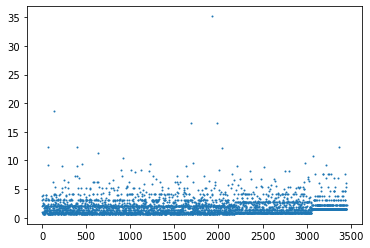

In [24]:
plt.scatter(np.arange(tf_idf_clusters.shape[1]),tf_idf_clusters.sum(axis=0)*1000,s=1)
np.sum(tf_idf_clusters.sum(axis=0) == 0)

## Clustering based on the computed scores matrix

In [62]:
X_train = np.asarray(scores)

In [73]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, init = "k-means++")

y_train = np.asarray(df.Sentiment.values)

kmeans.fit(X_train)
centroids = kmeans.cluster_centers_
y_pred_train = kmeans.labels_


79
Centroids:  [12.24169705  8.92512405 63.27396578]
0.9746835443037974


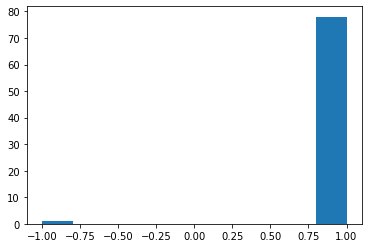

2028
Centroids:  [1.44086384 1.26002699 1.60047387]
0.16666666666666666


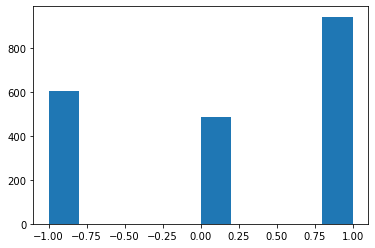

270
Centroids:  [ 5.80160692  5.17552147 23.35731595]
0.9481481481481482


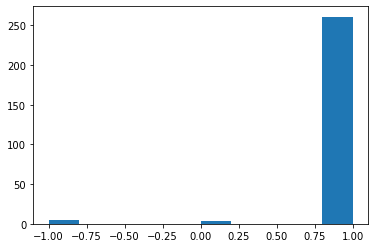

68
Centroids:  [80.18406109  7.09281633  7.15043663]
-1.0


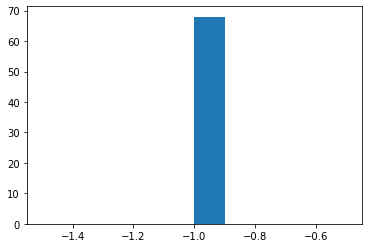

211
Centroids:  [39.06826927  4.19964363  6.58068943]
-0.9004739336492891


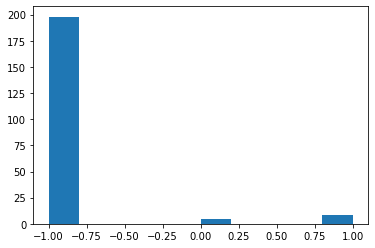

162
Centroids:  [ 5.52678322 24.23266267  6.12089529]
-0.006172839506172839


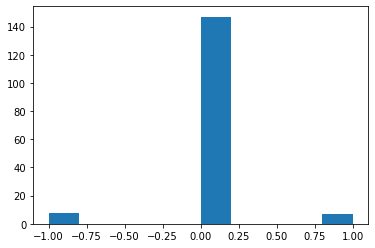

14
Centroids:  [  9.42248304   9.2566416  141.18950109]
1.0


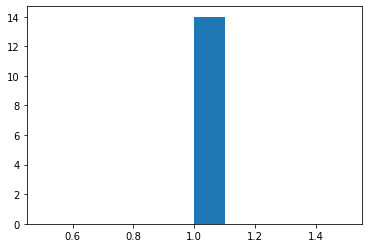

13
Centroids:  [150.67434837  19.75607191   9.89539029]
-1.0


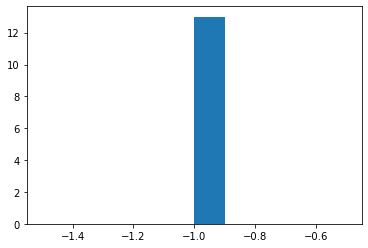

26
Centroids:  [27.47457607 90.50543807 15.42323778]
-0.19230769230769232


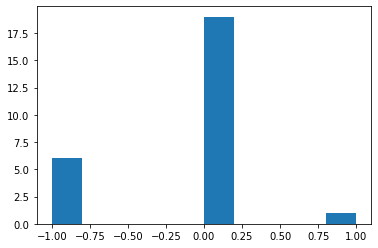

462
Centroids:  [16.50058953  2.72938021  3.77161561]
-0.6753246753246753


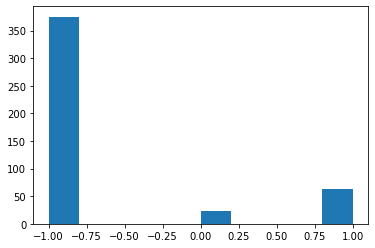

In [74]:
for i in range(n_clusters):
    print(np.sum(y_pred_train == i))
    print("Centroids: ", centroids[i])
    avg_score = np.mean(df['Sentiment'].loc[y_pred_train == i].values)
    print(avg_score)
    plt.hist(df.loc[y_pred_train == i]['Sentiment'])
    plt.show()


In [75]:
centroid_sentiments = centroids.argmax(axis=1)-1

In [76]:
sents = {'negative': 0, 'neutral': 1, 'positive': 2}

In [77]:
sentiment_mapping = dict(zip(np.unique(kmeans.labels_),centroid_sentiments))

In [79]:
y_pred = pd.Series(y_pred_train).map(sentiment_mapping).values

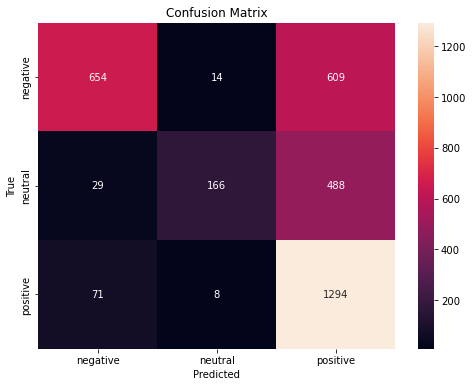

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot the confusion matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sents.keys(), yticklabels=sents.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()